# Description
#### The goal of this code is to validate the accuracy of the vehicle model. Basically, we want to see given a flight plan for the implemented vehicle, how much the uav model generated current is closer to the actual flight current.


From the current status of the project, this task seems a little difficult as the model obviously has difference. However, the general procedure that needs to be followed to achieve the task at hand will be:
- Get the actual position data of the flight
- Use that position data to simulate the uav
- Collect the current input to the battery from the simulated uav
- compare that current input to the actual current profile 

In [6]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
import collections
import pandas as pd
from scipy import stats
from scipy.stats import norm
from prog_algs.metrics import prob_success
from sklearn.preprocessing import normalize 
from pathlib import Path
import sys 
import utm 

sys.path.append('/home/abenezertaye/Desktop/Research/Codes/NASA/Battery Prognostics/Battery Prognostics/Plots and Results/')    

In [10]:
data_frame

,Lat,Long,Alt
0,38.835261,-77.506181,57.15
1,38.835261,-77.506181,57.12
2,38.835261,-77.506181,57.13
3,38.835261,-77.506181,57.10
4,38.835261,-77.506181,57.08
...,...,...,...
2122,38.835011,-77.505605,62.80
2123,38.835010,-77.505605,62.76
2124,38.835010,-77.505605,62.75
2125,38.835010,-77.505605,62.71


# Import flight data and convert to x and y pos

In [11]:
flight_number = 3
# Import the flight position 
# data_frame = pd.read_csv('./flight_positions/position_data_{flight_number}.csv'.format(flight_number=flight_number))

# altitude = data_frame['alt'].dropna().to_numpy()
# latitude = data_frame['lat'].dropna().to_numpy()
# longitude = data_frame['lng'].dropna().to_numpy()

data_frame = pd.read_csv('./flight_positions/GW_postion.csv')
altitude = data_frame['Alt'].dropna().to_numpy()
latitude = data_frame['Lat'].dropna().to_numpy()
longitude = data_frame['Long'].dropna().to_numpy()

# Convert the lat, lon to x & y
x, y,zone,U = utm.from_latlon(latitude, longitude)
x_reference, y_reference = x[0], y[0]

x = x - x_reference
y = y - y_reference
# ax = plt.figure().add_subplot(projection='3d')

# ax.plot(x, y, altitude)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plt.grid()
# plt.title('3D Trajectory')

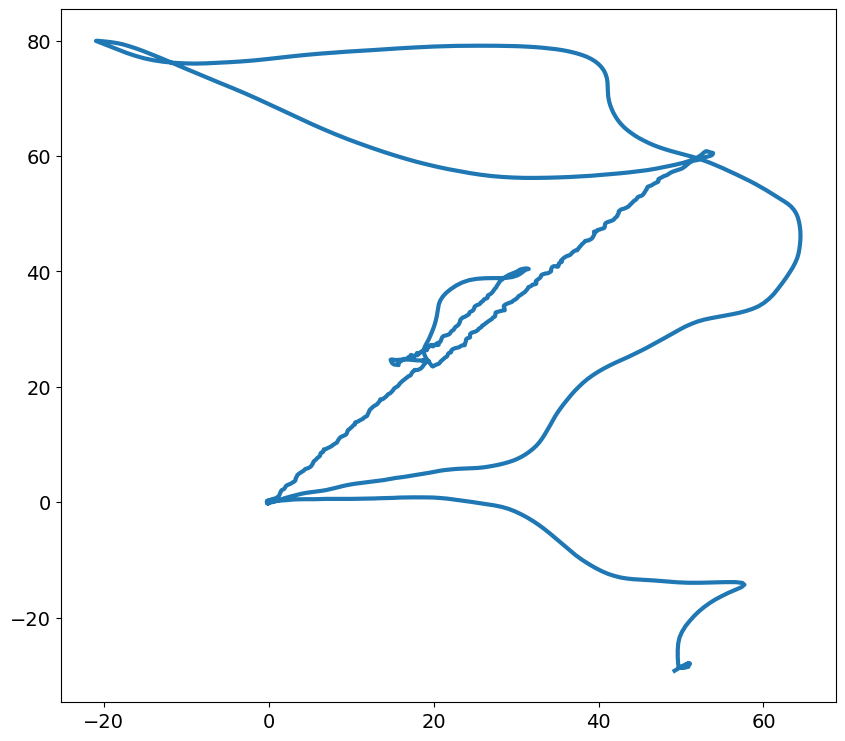

In [14]:
plt.plot(x,y)

# Import simulated x and y and convert to lat and long

In [190]:
# longer flight test
wp = np.asarray([
    [0.0, 0.0, 100.0],
    [600.0, 0.0, 100.0],
    [650.0, 30.0, 100.0],
    [650.0, 100.0, 100.0],
    [600.0, 120.0, 100.0],
    [50.0, 120.0, 100.0],
    [0.0, 150.0, 100.0],
    [0.0, 200.0, 100.0],
    [50.0, 250.0, 100.0],
    [600.0, 250.0, 100.0],
    [650.0, 300.0, 100.0],
    [650.0, 400.0, 100.0],
    [600.0, 450.0, 100.0],
    [0.0, 450.0, 100.0],
])

#shorter trajectory
wp = np.asarray([
    [0.0, 0.0, 100.0],
    [600.0, 0.0, 100.0],
    [650.0, 30.0, 100.0],
    [650.0, 100.0, 100.0],
    [600.0, 120.0, 100.0],
    [50.0, 120.0, 100.0],
    [0.0, 150.0, 100.0],
    [0.0, 200.0, 100.0],
    [50.0, 250.0, 100.0],
    [600.0, 250.0, 100.0],
#     [650.0, 300.0, 100.0],
#     [650.0, 400.0, 100.0],
#     [600.0, 450.0, 100.0],
#     [0.0, 450.0, 100.0],
])

x_reference, y_reference = 376740.66653360194, 4107116.8363571083

# interpolate the x and y pos 
x = wp[:,0] #+ x_reference
y = wp[:,1] #+ y_reference
path_y = np.zeros(1)
path_x = np.zeros(1)
for i in range(0,len(x)-1):
    segment_x = np.linspace(x[i],x[i+1],100)
    segment_y = np.linspace(y[i],y[i+1],100)
    path_x = np.concatenate((path_x, segment_x), axis=0)
    path_y = np.concatenate((path_y, segment_y), axis=0)


x = path_x + x_reference
y = path_y + y_reference

lat, long = utm.to_latlon(x, y, zone, U)

path = np.stack((lat, long), axis=1)
# convert array into dataframe
DF = pd.DataFrame(path)
 
# save the dataframe as a csv file
DF.to_csv("short_traj.csv")

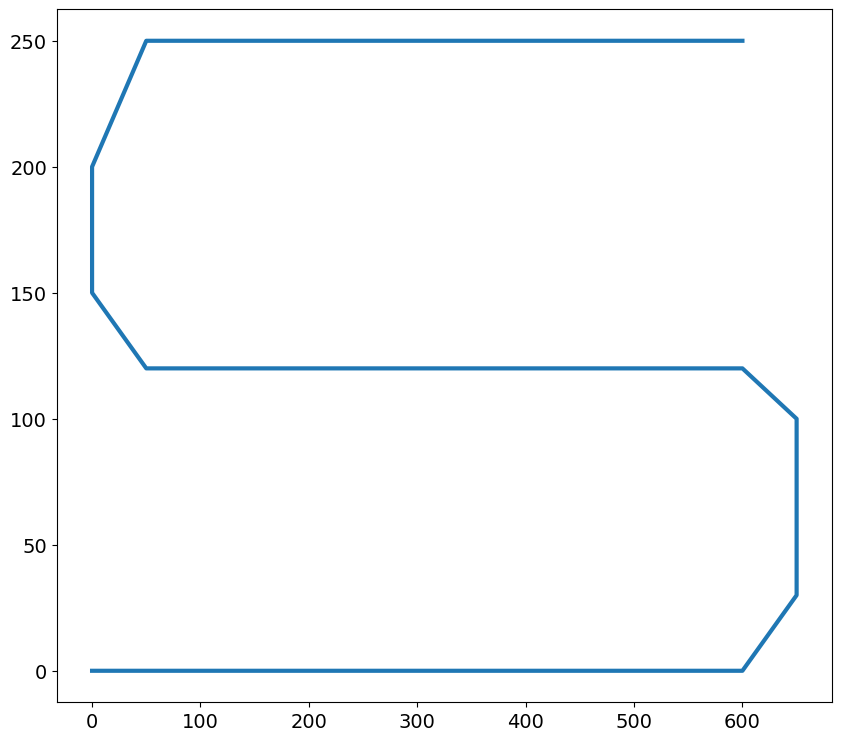

In [194]:
# plt.plot(x,y)
plt.plot(path_x,path_y)

# Export the lat and long of the trajectory

In [49]:
pos_csv = data_frame[['lat','lng']].to_csv('pos_csv_{flight_number}.csv'.format(flight_number=flight_number))

# Import the simulated current (in ms) and convert to 0.1 sec

In [3]:
# Import the current input of flight 1
Iapp = np.loadtxt('./current_inputs/Iapp_nowind_trajectory') # Actual trajectory - Flight 1
np.savetxt('Iapp_nowind',Iapp[::100])
# plt.plot(Iapp[::100])
# aa = np.loadtxt('Iapp_expt')

In [89]:
y_reference

4107116.8363571083

In [7]:
c = (1.5*(1.1)**2)
a = 9.81/1.1
print(a*c)

16.186500000000002
